In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from keras.datasets import mnist

2024-01-25 20:48:23.588252: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 20:48:23.616020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 20:48:23.616041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 20:48:23.616723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 20:48:23.621272: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from models import ConvUpscaleAutoEncoder

In [3]:
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0

In [4]:
def downscale(batch):
    return batch[..., ::3, ::3]

In [5]:
#x = torch.randn(1, 1, 28, 28)
#model = ConvUpscaleAutoEncoder()
#model(downscale(x))

#assert False

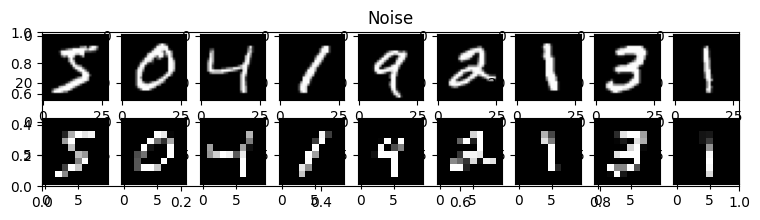

In [6]:
plt.figure(figsize=(9, 2))
plt.title("Noise")
plt.gray()
for i, img in enumerate(x_train[:9]):
    plt.subplot(2, 9, i+1)
    plt.imshow(img.reshape(28, 28))
for i, img in enumerate(x_train[:9]):
    plt.subplot(2, 9, 9+i+1)
    plt.imshow(downscale(img))

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 4
BATCH_SIZE = 128
LEARNING_RATE = 0.002

# train a convolutional autoencoder on MNIST
model = ConvUpscaleAutoEncoder().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()
inspections = []

for epoch in range(EPOCHS):
    print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS))
    epoch_loss = 0
    updates = 0

    for i in range(0, len(x_train), BATCH_SIZE):
        batch = x_train[i:i + BATCH_SIZE]

        # downscale batch
        downscaled_batch = downscale(batch.copy())

        batch = batch.reshape(-1, 1, 28, 28)
        batch = torch.from_numpy(batch).to(DEVICE)
        downscaled_batch = downscaled_batch.reshape(-1, 1, downscaled_batch.shape[1], downscaled_batch.shape[2])
        downscaled_batch = torch.from_numpy(downscaled_batch).to(DEVICE)

        # forward pass
        output = model(downscaled_batch)
        loss = criterion(output, batch)

        epoch_loss += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        updates += 1

        print(
            "update: " + str(updates) + "/" + str(len(x_train)//BATCH_SIZE + 1) + " | " +
            "loss: " + str(round(epoch_loss/((i + 1)*BATCH_SIZE), 4)), end="\r")

    print(
        "update: " + str(updates) + "/" + str(len(x_train)//BATCH_SIZE + 1) + " | " +
        "loss: " + str(round(epoch_loss/((i + 1)*BATCH_SIZE), 4)))

    if (epoch % 2 == 0 and len(inspections) < 4) or epoch == EPOCHS - 1:
        inspections.append((
            epoch, 
            downscaled_batch.to("cpu").detach().numpy(), 
            output.to("cpu").detach().numpy()
        ))

Epoch: 1/4
update: 469/469 | loss: 0.0
Epoch: 2/4
update: 469/469 | loss: 0.09
Epoch: 3/4
update: 469/469 | loss: 0.09
Epoch: 4/4
update: 469/469 | loss: 0.09


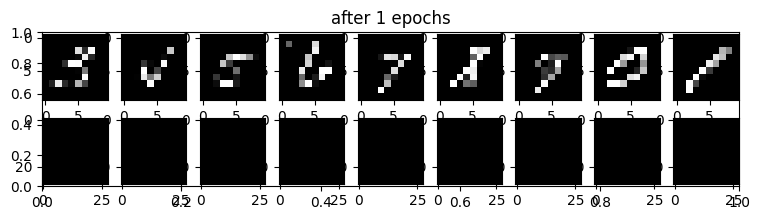

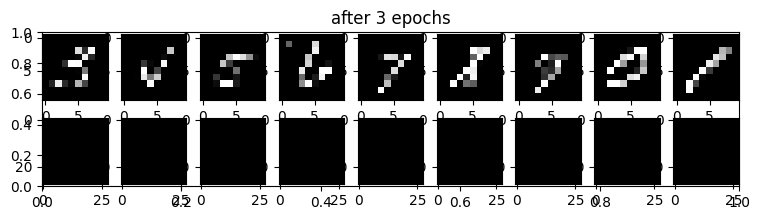

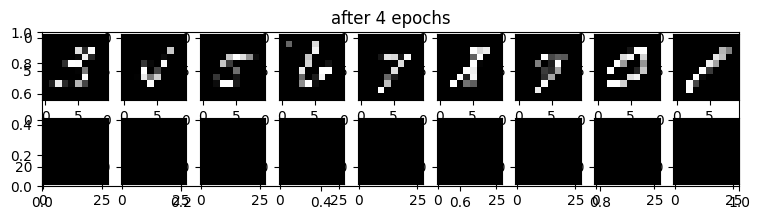

In [8]:
# examine how proficient the convolutional autoencoder is at reconstructing over epochs
for epoch, imgs, recons in inspections:
    plt.figure(figsize=(9, 2))
    plt.title("after " + str(epoch + 1) + " epochs")
    plt.gray()
    for i, img in enumerate(imgs[:9]):
        plt.subplot(2, 9, i+1)
        plt.imshow(img.reshape(10, 10))
    for i, recon in enumerate(recons[:9]):
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(recon.reshape(28, 28))